# 1 Package Loading and Preparing

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random

# tensorflow for denoising auto-encoder
import tensorflow as tf
from tensorflow.keras import layers, models

# from gluonts.dataset.common import ListDataset
# from gluonts.dataset.util import to_pandas

# from pts.model.deepar import DeepAREstimator
# from pts import Trainer
from sklearn.preprocessing import StandardScaler # to standaridze time series
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

In [3]:
## Fetch the Engery Sector SP500 Stocks


axp = yf.Ticker("AXP")
adj_close = axp.history(start = "2020-01-01", end = "2021-12-31")["Close"]

# 2020-2021 two year prices
sp500_index_train = yf.download('^GSPC', start='2012-01-01', end='2021-12-31')["Adj Close"]

# 2022 annual prices, to be predicted
sp500_index_test = yf.download('^GSPC', start='2022-01-01', end='2022-12-31')["Adj Close"]

adj_close = sp500_index_train
adj_close_df = pd.DataFrame(adj_close)
n = adj_close.shape[0]

# Extract adjusted closing prices
print(adj_close_df.head())
print(n)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
              Adj Close
Date                   
2012-01-03  1277.060059
2012-01-04  1277.300049
2012-01-05  1281.060059
2012-01-06  1277.810059
2012-01-09  1280.699951
2516


In [4]:
def create_moving_windows(df, window_length=30):
    """
    Function to create moving windows from a DataFrame with a DatetimeIndex.

    Parameters:
    df (pd.DataFrame): Input DataFrame with a DatetimeIndex.
    window_length (int): The length of the moving window.

    Returns:
    pd.DataFrame: A DataFrame containing all the moving windows.
    """
    # Initialize a list to hold the moving windows
    moving_windows = []

    # Loop over the DataFrame using the window size
    for start in range(len(df) - window_length + 1):
        # Select the window of data
        window_data = df.iloc[start:start + window_length]
        # Append the window data to the list
        moving_windows.append(window_data)

    # Convert the list of windows to a DataFrame
    windows_df = pd.concat(moving_windows, keys=range(len(moving_windows)))

    return windows_df

# Example usage:
# Assuming 'df' is our DataFrame with a DatetimeIndex, and we want a window length of 3
window_length = 30
windows_df = create_moving_windows(adj_close_df, window_length)

windows_df.head(100)  # Display the first 10 rows of the resulting DataFrame


Adj Close
  Date                   
0 2012-01-03  1277.060059
  2012-01-04  1277.300049
  2012-01-05  1281.060059
  2012-01-06  1277.810059
  2012-01-09  1280.699951
...                   ...
3 2012-01-13  1289.089966
  2012-01-17  1293.670044
  2012-01-18  1308.040039
  2012-01-19  1314.500000
  2012-01-20  1315.380005

[100 rows x 1 columns]

In [67]:
# Time Series Standardization
# from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_mean = np.mean(adj_close_df)
standardized_std = np.std(adj_close_df)

adj_close_std_df = adj_close_df.copy()
index_name = adj_close_df.index           # record the index date
columns_name = adj_close_df.columns       # record the column name
columns_to_std = ['Adj Close']            # columns to be standardized


adj_close_std_df[columns_to_std] = pd.DataFrame(
    scaler.fit_transform(adj_close_df[columns_to_std]),   # add back the index
    index = index_name, columns = columns_name)           # add back the column name

print(adj_close_std_df.head())
print(adj_close_df.head())

            Adj Close
Date                 
2012-01-03  -1.448311
2012-01-04  -1.448019
2012-01-05  -1.443459
2012-01-06  -1.447401
2012-01-09  -1.443896
              Adj Close
Date                   
2012-01-03  1277.060059
2012-01-04  1277.300049
2012-01-05  1281.060059
2012-01-06  1277.810059
2012-01-09  1280.699951


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


# Noise Perturbing

In [6]:
import math
import scipy.stats
import numpy as np
## Forward Markov Chain
## Perturbing noise in the price until totally random

def corrupt(ori_data, beta = None, t = 200):
  """
  Inputs:
    data: A Series
    t: An positive integer
    beta: A list of hyperparameters that control the variance of the noise
          within the range of [0,1] and is non-decreasing
  Output: A Series
  This function addes noise to the stock data and returns this stock data but pertubed
    t times.
  """
  data = ori_data.copy(deep = True)
  beta = [0.003] * t if beta == None else beta
  #beta = np.linspace(0, 0.3, t)

  alpha_bar = 1
  for i in range(t):
    alpha_bar *= 1 - beta[i]
    #alpha.append(1 - beta[i]) # reparameterized by the last hypermeter

  for i in range(len(data)): # pertubing noise n times into each observations of data
    data.iloc[i,0] = math.sqrt(alpha_bar) * data.iloc[i,0] + math.sqrt(1 - alpha_bar) * random.normalvariate(0,1)
  return data


class DiffusionModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(DiffusionModel, self).__init__()
    # Define the architecture using reversible transformations

  def forward(self, x):
    # Implement the forward pass through reversible transformations
    return x

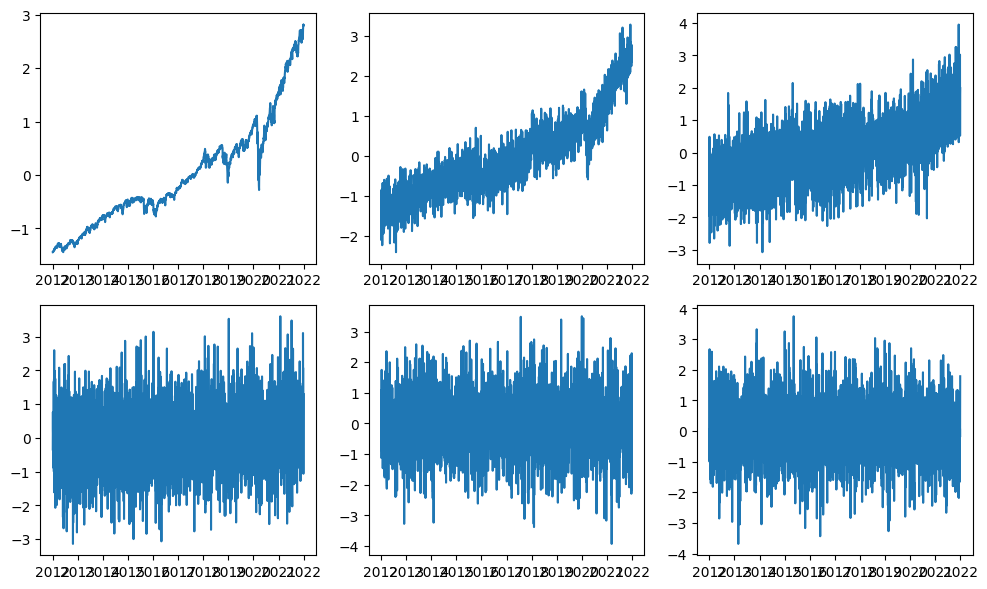

In [7]:
## Demo for the a aaaassaaaaaaaaaa
cor_axp = adj_close_std_df.copy(deep = True)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
fig_count = 0

for time in range(200):# add noise 200 times
  if time in [0, 9, 24, 54, 99, 199]:
    axes[fig_count // 3, fig_count % 3].plot(cor_axp)
    fig_count += 1
  cor_axp = corrupt(cor_axp, t =time) # add noise once

fig.tight_layout()

<Axes: xlabel='Date'>

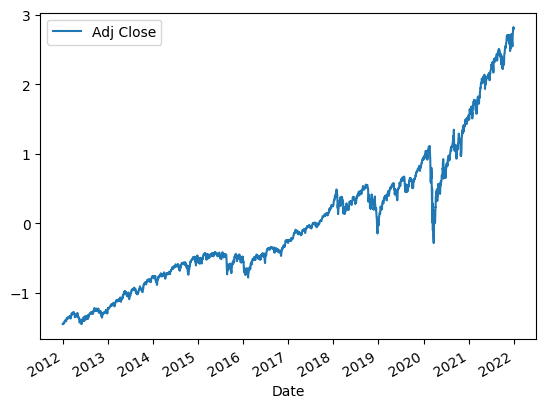

In [8]:
adj_close_std_df.plot()

## Denoising

Need to use Neural Network to calcluate the $\mu_Θ$.

In [9]:
def create_autoencoder(input_dim, encoding_dim):
  """
  This function creates and sets up the architecture for the denoising
    autoencoder using tensorflow.keras.
  Input:
    input_dim: A positive int
    encod_dim: A positive int
  Output:
    An autoencoder ready to denoise a noised array.
  """
  hidden_layer_size = 128
  # Define the encoder part of the autoencoder
  encoder_input = layers.Input(shape = (input_dim,))
  encoded = layers.Dense(hidden_layer_size,
                         activation = 'relu')(encoder_input)
  encoded = layers.Dense(encoding_dim,
                         activation = 'relu')(encoded)

  # Define the decoder part of the autoencoder
  decoded = layers.Dense(hidden_layer_size,
                         activation = 'relu')(encoded)
  decoded = layers.Dense(input_dim,
                         activation = 'elu')(decoded)

  # Create the autoencoder model
  return models.Model(encoder_input, decoded)

In [10]:
num_instances = 10      # number of denoised series to be generated
clean_ts_lst = []      # store the clean time series for the autoencoder
noisy_ts_lst = []      # store the noisy time series produced by the autoencoder

original_data = adj_close_std_df

for i in range(num_instances):
  #clean_ts = adj_close_std_df.sample(frac = 1).reset_index(drop = True)
  clean_ts = original_data.copy(deep = True)
  noisy_ts = corrupt(clean_ts, t = 2000) # Add noise to the clean data
  # Store the clean and noisy time series data
  clean_ts_lst.append(clean_ts)
  noisy_ts_lst.append(noisy_ts)

# Convert the lists of time series (each as a DataFrame) to numpy arrays
clean_ts_arr = np.array(clean_ts_lst)
noisy_ts_arr = np.array(noisy_ts_lst)

# Define input and encoding dimensions for the autoencoder
input_dim = clean_ts_arr[0].shape[0]
encoding_dim = clean_ts_arr[0].shape[0]
print(input_dim, encoding_dim)

# Create and train the autoencoder
autoencoder = create_autoencoder(input_dim, encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(noisy_ts_arr, clean_ts_arr, epochs=32, batch_size=32, shuffle=True)

# Generate denoised data using the trained autoencoder
denoised_ts_arr = autoencoder.predict(noisy_ts_arr)

2516 2516
Epoch 1/32
1/1 [==============================] - 6s 6s/step - loss: 1.0031
Epoch 2/32
1/1 [==============================] - 0s 8ms/step - loss: 0.9593
Epoch 3/32
1/1 [==============================] - 0s 8ms/step - loss: 0.8631
Epoch 4/32
1/1 [==============================] - 0s 7ms/step - loss: 0.7230
Epoch 5/32
1/1 [==============================] - 0s 8ms/step - loss: 0.6194
Epoch 6/32
1/1 [==============================] - 0s 8ms/step - loss: 0.4808
Epoch 7/32
1/1 [==============================] - 0s 7ms/step - loss: 0.3658
Epoch 8/32
1/1 [==============================] - 0s 8ms/step - loss: 0.2830
Epoch 9/32
1/1 [==============================] - 0s 8ms/step - loss: 0.2103
Epoch 10/32
1/1 [==============================] - 0s 8ms/step - loss: 0.1606
Epoch 11/32
1/1 [==============================] - 0s 8ms/step - loss: 0.1212
Epoch 12/32
1/1 [==============================] - 0s 8ms/step - loss: 0.0911
Epoch 13/32
1/1 [==============================] - 0s 8ms/step -

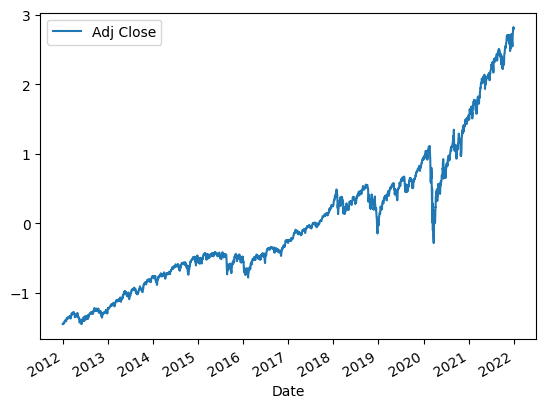

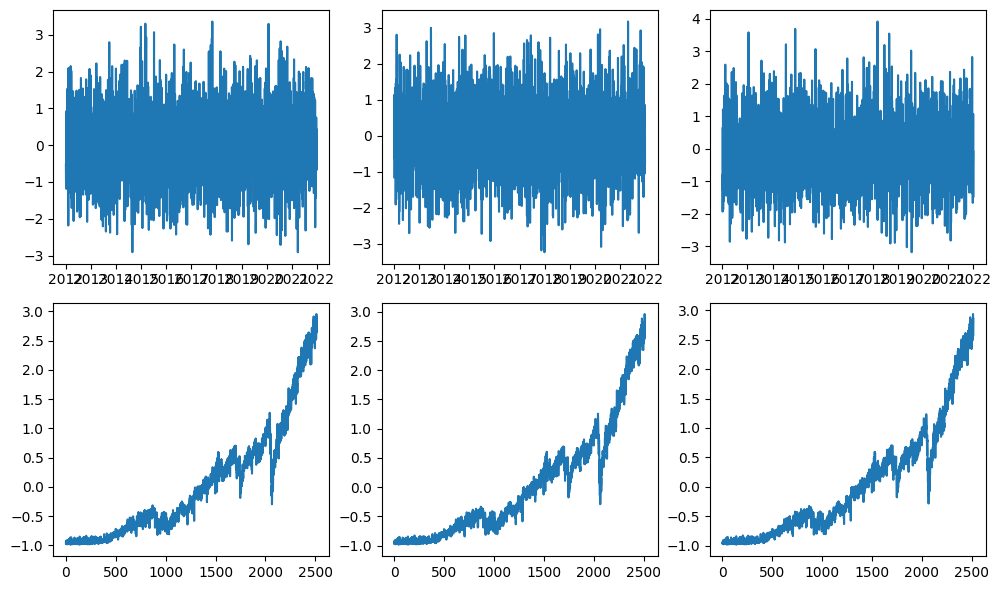

In [11]:
# Demo
adj_close_std_df.plot()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
for fig_count in range(3):
  axes[0, fig_count % 3].plot(noisy_ts_lst[fig_count])
  axes[1, fig_count % 3].plot(denoised_ts_arr[fig_count])
fig.tight_layout()

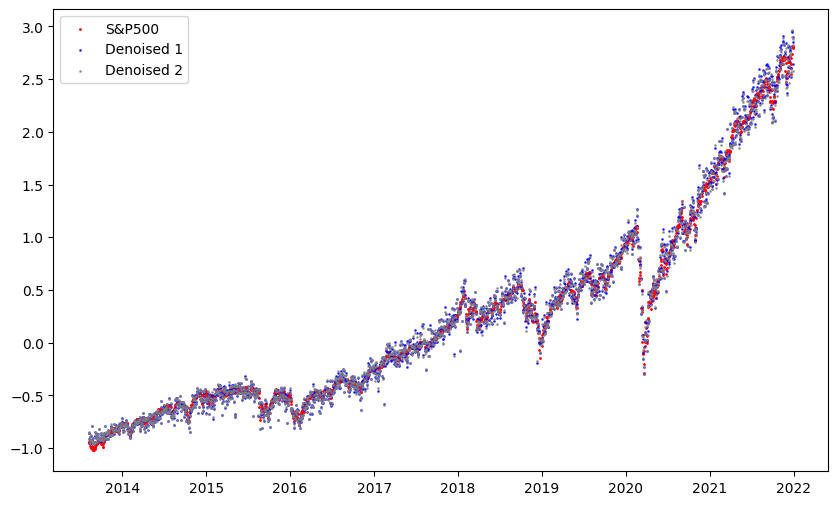

In [21]:
# Plot the clean data (SP500) and the denoised time series together
denoise_demo_df_1 = pd.DataFrame(denoised_ts_arr[0],
                            columns = adj_close_std_df.columns,
                            index = adj_close_std_df.index)
denoise_demo_df_2 = pd.DataFrame(denoised_ts_arr[1],
                            columns = adj_close_std_df.columns,
                            index = adj_close_std_df.index)

plt.figure(figsize = (10,6))
plt.scatter(adj_close_std_df.index[400:], adj_close_std_df[400:],
            color = 'red', label = 'S&P500', s = 1)
plt.scatter(denoise_demo_df_1.index[400:], denoise_demo_df_1[400:],
            s = 0.8, alpha = 0.8, color = 'blue', label = 'Denoised 1')
plt.scatter(denoise_demo_df_2.index[400:], denoise_demo_df_2[400:],
            s = 0.8, alpha = 0.8, color = 'grey', label = 'Denoised 2')

plt.legend()
plt.show()


# MLP

# Data Dividing

In [33]:
## Assgined to Yanda
### Could try different time steps  (e.g. 7-day)
### Reference: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
# univariate data preparation
# split a univariate sequence into samples
import numpy as np
import pandas as pd

def split_sequence(df_arr, n_steps=30):
  """
    Split a given univariate Series into multiple segments with length equal to steps.
    Input:
        df_arr: An Array of DataFrame
        n_steps: A positive int ; default value = 30
    Output:
        An array of X that represents the segment of the time series.
        An array of y that represents the target of the time series.
  """
  X_list, y_list = [], []
  for idx in range(len(df_arr)):
    data = df_arr[idx]  # Extract values from DataFrame

    for i in range(len(data) - n_steps):
      end_ix = i + n_steps
      seq_x, seq_y = data[i:end_ix], data[end_ix]
      X_list.append(seq_x)
      y_list.append(seq_y)

  return np.array(X_list), np.array(y_list)

# MLP

In [56]:
#X, y = split_sequence(denoised_ts_arr, n_steps= 365)

print(type(denoised_ts_arr))
print(type(denoised_ts_arr[0]))

demo = np.array(adj_close_std_df.iloc[:,0])
demo_lst = []
demo_lst.append(demo)

#samller example
X, y = split_sequence(demo_lst, n_steps= 365)

print(X.shape, y.shape)
print(y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2151, 365) (2151,)
[-0.99378248 -1.02153326 -1.07094626 ...  2.8080491   2.8161875
  2.79880679]


In [60]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = 365))
model.add(Dense(100))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)


In [81]:
# demonstrate prediction
x_input = np.array(adj_close_std_df[-365:]).reshape((1, 365))
yhat = model.predict(x_input, verbose=0)[0]
for i in range(len(yhat)):
  yhat[i] = yhat[i] * standardized_std + standardized_mean
predict_yhat = pd.DataFrame(yhat, columns = adj_close_std_df.columns,
                            index = sp500_index_test.index[:len(yhat)])


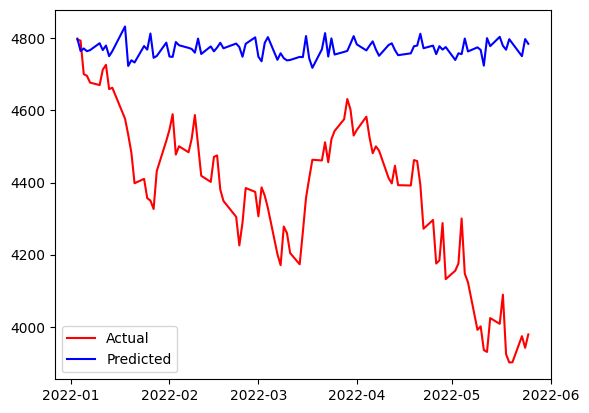

In [86]:
plt.plot(sp500_index_test[:100], label = "Actual", color = "red")
plt.plot(predict_yhat, label = "Predicted", color = "blue")
plt.legend()
plt.show()